## An introduction to working with the Cadence Simulations for the AGN SC

### Initial Setup
This notebook provides a crash-course to the "official" crash-course overview.  The projects' crash-course notebook will be in the following place (once you follow the directions below):
/home/mount/sims_maf_contrib/tutorials/Introduction Notebook.ipynb

See also
/home/mount/sims_maf_contrib/tutorials/Write a New Metric.ipynb
and further tutorials for more in-depth examples.

To use this notebook, you need to do the following:
- install docker
- create a folder to work in (e.g., /Users/gtr/Dropbox/LSST/DockerShared)
- in that folder, on a command line execute: `docker pull wyu16/lsst_sims:j_maf_19_11_05`
- then execute: `docker run -d -p 9000:8888 --name maf -v /local/path/:home/mount/ wyu16/lsst_sims:j_maf_19_11_05`
- now open a browser (chrome ideally) and go to https://github.com/LSST-nonproject/sims_maf_contrib
- again in the folder from step 2, execute: `git clone https://github.com/lsst/sims_maf_contrib`
- make a subfolder to store your opSim db files (e.g., /Users/gtr/Dropbox/LSST/DockerShared/dbFiles)
- go to http://astro-lsst-01.astro.washington.edu:8081/?runId=67
- download 2 "db" files to compare (and put them in the folder above)
- open jupyter lab in your browser with `http://localhost:9000/`

### Returning Setup

If you have already done the above and are coming back to this later (e.g., after shutting down your computer), then instead of executing the `docker run` command above, restart Docker with
- `docker start maf`

<b>Now we can start computing metrics to use for comparing different opSims.</b>

### Software Setup (repeat each session)

In [1]:
# import matplotlib to show plots inline.
%matplotlib inline
import matplotlib.pyplot as plt

Import the sims_maf modules needed.

In [2]:
# import our python modules
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

### Metrics for beginners

We'd like to compare 2 or more opSims to determine which is "best" for our science.  

In order to do this, we are first going to need to define a `metric`: 
- a `metric` calculates some quantity that you want to measure (e.g. the mean value of an attribute such as the airmass). 

Then we need to know how you want to split the data by defining a `slicer`:
- a `slicer` takes the list of visits from a simulated survey and orders or groups them (e.g. by night or by region on the sky).

Finally, we need to provide a `constraint`:

- a constraint applies a SQL selection to the visits you want to select from the simulated survey database (such as 'filter = "r"')

<br>

The combination of a <font color='green'> metric </font>, <font color='red'> slicer </font>, and <font color='blue'> constraint </font> is referred to as a `MetricBundle`. 

Here are examples of some simple `MetricBundle`s: 
- <font color='green'>coadded depth</font> <font color='red'> at each point in the sky</font> <font color='blue'> in r band</font> == 'Coaddm5Metric' + 'HealpixSlicer' + 'filter = "r"'
- <font color='green'>median airmass</font> <font color='red'>at each point in the sky</font> <font color='blue'> in i band </font> == 'MedianMetric(col="airmass")' + 'HealpixSlicer' + 'filter = "i"'
- <font color='green'>number of visits</font> <font color='red'>in each night</font> == 'CountMetric()'</font> + 'OneDSlicer(col='night')' + None
- <font color='green'>median skybrightness</font> <font color='red'>of all visits</font> <font color='blue'> in u band </font> = 'MedianMetric(col='skybrightness')' + 'UniSlicer' + 'filter = "u"'

### Example MetricBundle Code
The following code segment generates the inputs to a `MetricBundle` that will calculate the <font color='green'>maximum airmass value</font> <font color='red'> at each point of the sky</font> <font color='blue'>in the $g$ band</font>.  We are also going to ignore the Deep Drilling Fields (DDFs) in this example.

In [3]:
# metric = the "maximum" of the "airmass" for each group of visits in the slicer
metric1 = metrics.MaxMetric('airmass')

# slicer = a grouping or subdivision of visits for the simulated survey
# based on their position on the sky (using a Healpix grid)
slicer1 = slicers.HealpixSlicer(nside=64)

# constraint = the sql query (or 'select') that selects all visits in r band
constraint1 = 'filter = "g"'
constraint1 += ' and note not like "DD%"' # added so the sky plot won't saturate (remove DDFs)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


### Define a MetricBundle
Next we define the metric bundle itself, which includes the `metric`, `slicer`, and `constraints`.

In [4]:
# MetricBundle = combination of the metric, slicer, and sqlconstraint
maxairmassSky = metricBundles.MetricBundle(metric1, slicer1, constraint1)

### Combining Metrics

We can also combine multiple MetricBundles and run them all at once to calculate their metric values.  We do this by combining the metrics into a dictionary, creating a `MetricBundleGroup`. For now we will use calculate the metric values for our single 'maxairmassSky' MetricBundle. 

In [5]:
bundleDict = {'maxairmassSky': maxairmassSky}

### Choosing the simulated survey database (opSim) to analyze
The input data is queried from a database (usually a SQLite database).

In [6]:
#Read in an opSim (in this case "baseline_v1.3_10yrs.db")
opsdb1 = db.OpsimDatabase('/home/mount/dbFiles/baseline_v1.3_10yrs.db')

Create an output folder, 'outDir', that will track the results in another database ('resultsDb_sqlite.db').

In [7]:
outDir = '/home/mount/dbFiles/MAF_output'
resultsDb = db.ResultsDb(outDir=outDir)

### Running the Analysis
We generate the outputs by combining the bundle dictionary with the input database and output directories and database, then using the `MetricBundleGroup` class.

The MetricBundleGroup will query the data from the opsim database and calculate the metric values, using the 'runAll' method. 

In [8]:
group = metricBundles.MetricBundleGroup(bundleDict, opsdb1, outDir=outDir, resultsDb=resultsDb)
group.runAll()

Querying database SummaryAllProps with constraint filter = "g" and note not like "DD%" for columns ['fieldRA', 'airmass', 'fieldDec']
Found 186312 visits
Running:  ['maxairmassSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


### Visualizing the output
We can now visualize the results of running these metrics. With a HealpixSlicer, the default is to generate 3 plots:
- the metric as a function of position on the sky (in a Healpix projection)
- a histogram of the metric distribution for the pixels in the Healpix projection
- the angular powers pectrum of the metric

Where in this example, the metric is the maximum airmass.

Plotting figures with "filter = "g" and note not like "DD%"" constraint now.
monopole: 1.58172  dipole: lon: -7.21206, lat: 61.8338, amp: 0.153747
Plotting complete.


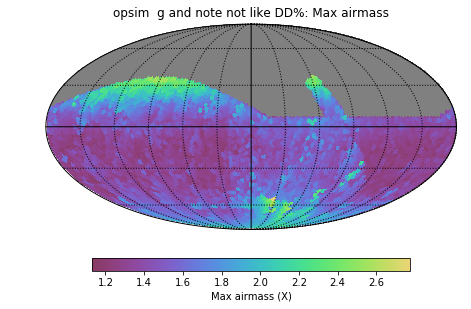

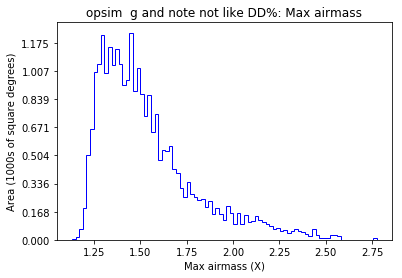

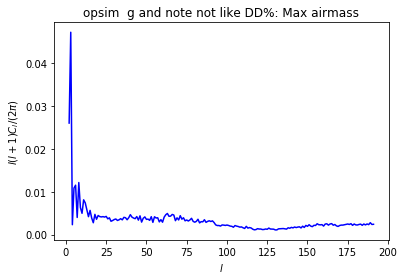

In [9]:
group.plotAll(closefigs=False)

---

### Extending the analysis: Adding more metrics, more information, and more opSims

Our goal is to answer the question of which opSim is "best" for any given science. Or perhaps simply which of two opSim is the "better" of the two.  

We'll now illustrate two metrics specifically related to two AGN goals:
- Selection of $z>7$ quasars
- Using DCR to improve photo-z estimation

We could define fairly sophisticated metrics to estimate how well we'll do for each, but we'll start with simple proxies:
- Coadded y-band depth
- Maximum g-band airmass

We have already created the `MetricBundle` for the 2nd metric.  Now we'll define one (`coAddY') for the 1st using the same slicer. To do this we use the 'Coaddm5Metric' and new sql constraint 'filter = "y"'.

In [10]:
metric2 = metrics.Coaddm5Metric()
constraint2 = 'filter = "y"'
constraint2 += ' and note not like "DD%"' # added so the sky plot won't saturate (remove DDFs)

coAddY = metricBundles.MetricBundle(metric2, slicer1, constraint2)

We can also add ["summary metrics"](https://confluence.lsstcorp.org/display/SIM/MAF+Summary+Statistics) to each MetricBundle. These metrics  generate statistical summaries of the metric data values (e.g. the means of the number of visits per point on the sky).

In [11]:
summaryMetrics = [metrics.MinMetric(), metrics.MedianMetric(),
                  metrics.MaxMetric(), metrics.RmsMetric()]
maxairmassSky.setSummaryMetrics(summaryMetrics)
coAddY.setSummaryMetrics(summaryMetrics)

### Grouping MetricBundles together 
We can group these metricBundles together into a dictionary, and pass this to the MetricBundleGroup, which will run them together. 

In [12]:
bundleDict = {'maxairmassSky': maxairmassSky, 'coAddY': coAddY}

### Define Plots to Create

Now we'll define which plots are going to be produced in our analysis.  In this case, we'll create both a histogram of our `metric` and a sky map (that essentially shows our `slicer`), but we'll leave off the angular power spectrum.

In [13]:
# plots to generate for this specific metric bundle
healpixhist = plots.HealpixHistogram()
healpixSky = plots.HealpixSkyMap()
plot_funcs = [healpixSky, healpixhist]
plot_dicts = {'left':1, 'right':2.8}

### Redefine MetricBundles and BundleDicts

To include only the above plots and adding a label for each opSim that will be useful for the comparison plots below.

In [14]:
maxairmassSky1 = metricBundles.MetricBundle(metric1, slicer1, constraint1, \
                                           plotFuncs=plot_funcs, plotDict=plot_dicts, \
                                           runName='baseline_v1.3_10yrs')
coAddY1 = metricBundles.MetricBundle(metric2, slicer1, constraint2, \
                                    plotFuncs=plot_funcs, plotDict=plot_dicts, \
                                    runName='baseline_v1.3_10yrs')
maxairmassSky1.setSummaryMetrics(summaryMetrics)
coAddY1.setSummaryMetrics(summaryMetrics)

bundleDict1 = {'maxairmassSky': maxairmassSky1, 'coAddY': coAddY1}

### Define MetricBundleGroup for these two MetricBundles and run our on opSim of choice

In [15]:
group1 = metricBundles.MetricBundleGroup(bundleDict1, opsdb1, \
                                        outDir=outDir, resultsDb=resultsDb)

Querying database SummaryAllProps with constraint filter = "g" and note not like "DD%" for columns ['fieldRA', 'airmass', 'fieldDec']
Found 186312 visits
Running:  ['maxairmassSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = "y" and note not like "DD%" for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec']
Found 380122 visits
Running:  ['coAddY']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter = "g" and note not like "DD%"" constraint now.
Plotting complete.
Plotting figures with "filter = "y" and note not like "DD%"" constraint now.
Plotting complete.


/home/lsst/stack/miniconda3-4.5.12-1172c30/Linux64/sims_maf/2.13.0.sims-11-gf62d2ead+9/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make 239 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


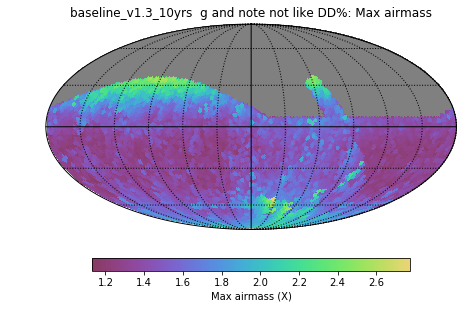

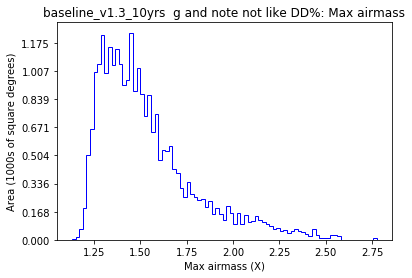

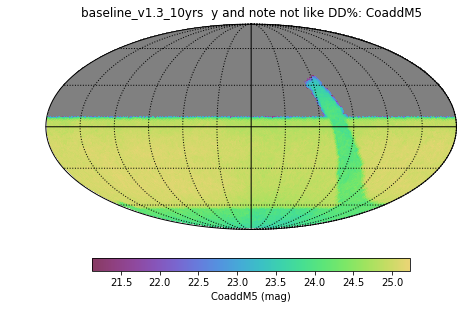

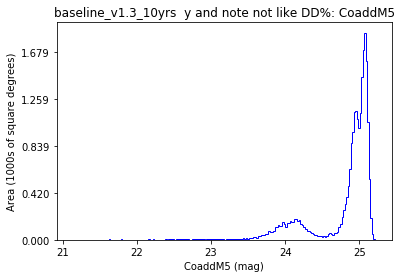

In [16]:
group1.runAll()
group1.plotAll(closefigs=False, savefig=False)

### Analyze a 2nd opSim

Now we'll analyze a second opSim, specifically `dcr_nham3_v1.3_10yrs.db`, which was designed to test possible changes to the cadence that would benefit DCR analysis.

In [17]:
# init new db connection
opsdb2 = db.OpsimDatabase('/home/mount/dbFiles/dcr_nham3_v1.3_10yrs.db')

In [18]:
maxairmassSky2 = metricBundles.MetricBundle(metric1, slicer1, constraint1, \
                                           plotFuncs=plot_funcs, plotDict=plot_dicts, \
                                           runName='dcr_nham3_v1.3_10yrs')
coAddY2 = metricBundles.MetricBundle(metric2, slicer1, constraint2, \
                                    plotFuncs=plot_funcs, plotDict=plot_dicts, \
                                    runName='dcr_nham3_v1.3_10yrs')
maxairmassSky2.setSummaryMetrics(summaryMetrics)
coAddY2.setSummaryMetrics(summaryMetrics)

bundleDict2 = {'maxairmassSky': maxairmassSky2, 'coAddY': coAddY2}

In [19]:
group2 = metricBundles.MetricBundleGroup(bundleDict2, opsdb2, outDir=outDir, resultsDb=resultsDb)
group2.runAll()

Querying database SummaryAllProps with constraint filter = "g" and note not like "DD%" for columns ['fieldRA', 'airmass', 'fieldDec']
Found 304682 visits
Running:  ['maxairmassSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = "y" and note not like "DD%" for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec']
Found 341098 visits
Running:  ['coAddY']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


### Compare Metrics for Both opSims

Let's plot a histogram of each metric with the two opSim results overplotted.

/home/lsst/stack/miniconda3-4.5.12-1172c30/Linux64/sims_maf/2.13.0.sims-11-gf62d2ead+9/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make 317 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))
/home/lsst/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/lsst/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in

2

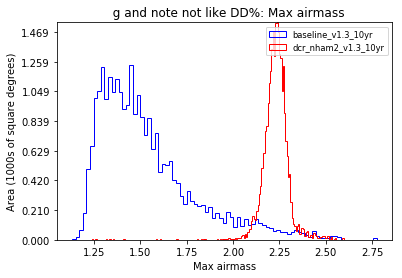

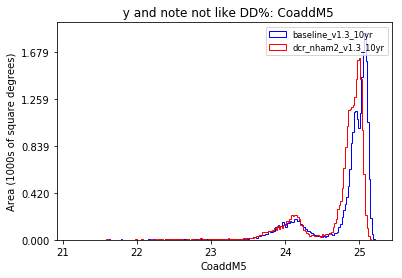

In [20]:
# init handler
ph = plots.PlotHandler(outDir=outDir, resultsDb=resultsDb)

# set metrics to plot togehter
ph.setMetricBundles([group1.bundleDict['maxairmassSky'], group2.bundleDict['maxairmassSky']])
plotDicts = [{'label':'baseline_v1.3_10yr', 'color':'b'}, \
             {'label':'dcr_nham2_v1.3_10yr', 'color':'r'}]
ph.plot(plotFunc = healpixhist, plotDicts=plotDicts)

# reset the metrics to plot togehter
ph.setMetricBundles([group1.bundleDict['coAddY'], group2.bundleDict['coAddY']])
ph.plot(plotFunc = healpixhist, plotDicts=plotDicts)

So, you can see that there is a pretty big difference between these opSims in terms of the DCR photo-z metric, but not much difference in terms of the $z>7$ metric.  We'd need to check the other opSims to see how they compare in that regard.

We can similarly create the sky plots (not overplotted clearly, but at least plotted together).

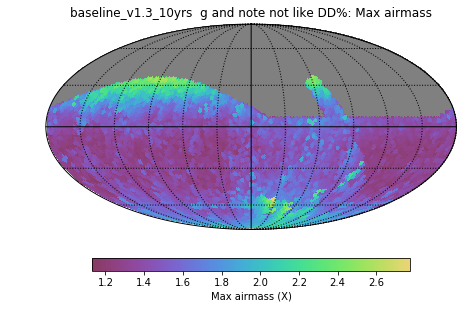

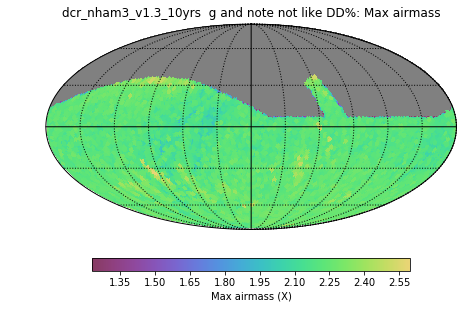

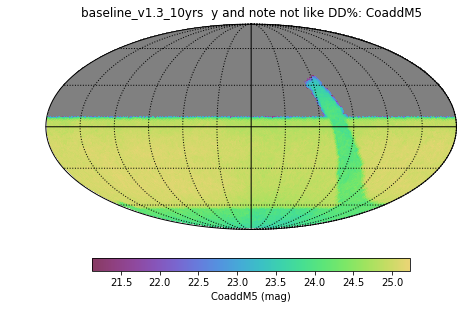

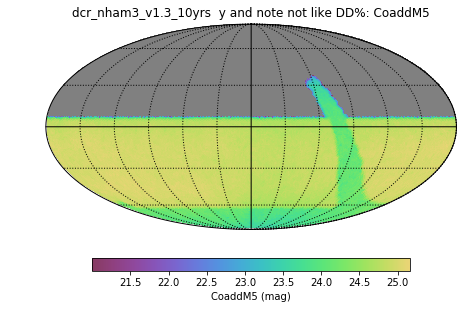

In [21]:
metricbdList = [group1.bundleDict['maxairmassSky'], group2.bundleDict['maxairmassSky'],\
               group1.bundleDict['coAddY'], group2.bundleDict['coAddY']]
for metricbd in metricbdList:
    metricbd.plot(plotFunc=healpixSky)

---

### Accessing the data generated by a metric

The results of the metric calculation are stored as an attribute in each metricBundle, as 'metricValues' - a numpy masked array. (**The structure of 'metricValues' will depend on how the data is sliced, e.g., if 'Healpix' slicer is used, each value represent the evaluate metric in each healpix pixel, or if you slice the cadence by night, then each value in the array will be the metric evaluated per night. So care should be taken when trying to generate plots directly from data in 'metricValues'**). The results of the summary statistics are also stored in each metricBundle, in an attribute called 'summaryValues', which is a dictionary of the summary metric name and value. 

For maxairmassSky, the metricValues are an array of max airmass (in g band) on the sky for each healpix pixel and the summaryValues are the mean, median etc of the these values. 

In [22]:
print("Array with the max airmass per pixel:", maxairmassSky.metricValues)

Array with the max airmass per pixel: [-- -- -- ... 2.0292181826926132 2.0292181826926132 2.0347025049842085]


N.B. The values of some metricValues above are shown as '--' because there were no opsim visits for those healpix points.

### Show summary statstics  

Note: Since we redefined the metricbundles before adding in the summary statistics, we need to access summary statistics from the 'maxairmassSky1' metric bundle.

In [23]:
print("Summary of the max, median, min,",
      "and rms of max airmass per pixel",
      maxairmassSky1.summaryValues)

Summary of the max, median, min, and rms of max airmass per pixel {'Min': 1.1322811283967413, 'Median': 1.4701858064862527, 'Max': 2.7737609701210033, 'Rms': 0.26385528072995607}


### Making your own plots

We can now generate plots directly using the data from 'metricValues' (i.e., instead of using the built-in tools above.)

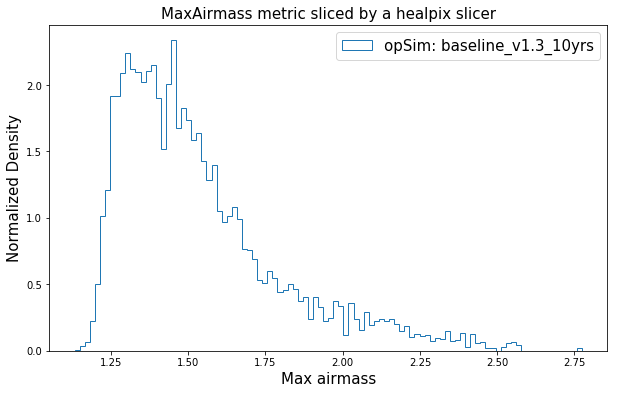

In [24]:
# need to mask the pixels that have no available data
mask = maxairmassSky.metricValues.mask
data = maxairmassSky.metricValues.data[~mask]

# plot
fig = plt.figure(figsize=(10,6))
_ = plt.hist(data, bins=100, histtype='step', density=True, label='opSim: baseline_v1.3_10yrs')
plt.title('MaxAirmass metric sliced by a healpix slicer', fontsize=15)
plt.xlabel('Max airmass', fontsize=15)
plt.ylabel('Normalized Density', fontsize=15)
plt.legend(fontsize=15)

If you have gotten to this point, you are then ready to try creating more complicated metrics, analyzing more opSims, etc.!

As noted above, see
/home/mount/sims_maf_contrib/tutorials/Introduction Notebook.ipynb
and
/home/mount/sims_maf_contrib/tutorials/Write a New Metric.ipynb
for further tutorials for more in-depth examples.